In [8]:
from d2l import torch as d2l
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.nn import functional as F

1. What could happen when we change the behavior of a search engine? What might the users do? What about the advertisers?

If the changes result in more accurate and relevant search results, users might have a better experience and find the information they’re looking for more easily. On the other hand, if the changes lead to less relevant results, users might become frustrated and dissatisfied with the search engine’s performance.

Advertisers might need to modify their advertising strategies, keywords, and targeting parameters to align with the new search engine behavior. If the changes lead to decreased ad performance, advertisers might experience reduced return on investment (ROI) and might reconsider their advertising budgets on that platform.

2. Implement a covariate shift detector. Hint: build a classifier.

I can mix two dataset and give them 0/1 label. Then I use a softmax classifier to distinguish these two datasets. If the test accuracy is bigger than a threshold, there may be exsiting a covariate shift.

auc: 0.5004000067710876


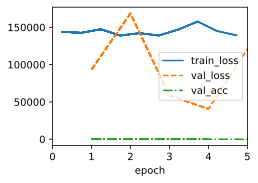

In [6]:
def accuracy(Y_hat, Y, averaged=True):
    """Compute the number of correct predictions."""
    Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
    preds = Y_hat.argmax(axis=1).type(Y.dtype)
    compare = (preds == Y.reshape(-1)).type(torch.float32)
    return compare.mean() if averaged else compare

class SameDataSet(d2l.DataModule):
    def __init__(self, batch_size=64, resize=(28, 28)):
        super().__init__()
        self.save_hyperparameters()
        trans = transforms.Compose([transforms.Resize(resize),
                                    transforms.ToTensor()])
        dataset1 = torchvision.datasets.FashionMNIST(
            root=self.root, train=True, transform=trans, download=True)
        dataset2 = torchvision.datasets.FashionMNIST(
            root=self.root, train=False, transform=trans, download=True)
        
        random_rows_indices = torch.randperm(dataset1.data.size(0))
        num_rows_to_select = dataset2.data.shape[0]//2

        self.train_X = torch.cat(
            (dataset1.data[random_rows_indices[:num_rows_to_select]],
             dataset2.data[:num_rows_to_select]), dim=0).type(torch.float32)
        self.train_y = torch.cat((torch.ones(num_rows_to_select),
                             torch.zeros(num_rows_to_select)), dim=0).type(torch.int64)
        self.val_X = torch.cat((dataset1.data[random_rows_indices[num_rows_to_select:2*num_rows_to_select]],
            dataset2.data[num_rows_to_select:2*num_rows_to_select]),
                          dim=0).type(torch.float32)
        self.val_y = torch.cat((torch.ones(num_rows_to_select),
                           torch.zeros(num_rows_to_select)), dim=0).type(torch.int64)
        self.train = torch.utils.data.TensorDataset(self.train_X, self.train_y)
        self.val = torch.utils.data.TensorDataset(self.val_X, self.val_y)
    
    def get_dataloader(self, train):
        data = self.train if train else self.val
        return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                        num_workers=self.num_workers)

data = SameDataSet()
model = d2l.SoftmaxRegression(num_outputs=2, lr=0.1)
trainer = d2l.Trainer(max_epochs=5)
trainer.fit(model, data)
y_hat=model.net(data.val_X)
print(f'val_acc: {accuracy(y_hat, data.val_y)}')

val_acc: 0.9941999912261963


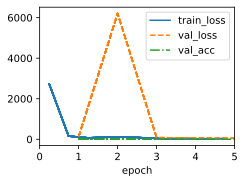

In [7]:
class DifferentDataSet(d2l.DataModule):
    def __init__(self, batch_size=64, resize=(28, 28)):
        super().__init__()
        self.save_hyperparameters()
        trans = transforms.Compose([transforms.Resize(resize),
                                    transforms.ToTensor()])
        dataset1 = torchvision.datasets.FashionMNIST(
            root=self.root, train=True, transform=trans, download=True)
        dataset2 = torchvision.datasets.MNIST(
            root=self.root, train=False, transform=trans, download=True)
        
        random_rows_indices = torch.randperm(dataset1.data.size(0))
        num_rows_to_select = dataset2.data.shape[0]//2

        self.train_X = torch.cat(
            (dataset1.data[random_rows_indices[:num_rows_to_select]],
             dataset2.data[:num_rows_to_select]), dim=0).type(torch.float32)
        self.train_y = torch.cat((torch.ones(num_rows_to_select),
                             torch.zeros(num_rows_to_select)), dim=0).type(torch.int64)
        self.val_X = torch.cat((dataset1.data[random_rows_indices[num_rows_to_select:2*num_rows_to_select]],
            dataset2.data[num_rows_to_select:2*num_rows_to_select]),
                          dim=0).type(torch.float32)
        self.val_y = torch.cat((torch.ones(num_rows_to_select),
                           torch.zeros(num_rows_to_select)), dim=0).type(torch.int64)
        self.train = torch.utils.data.TensorDataset(self.train_X, self.train_y)
        self.val = torch.utils.data.TensorDataset(self.val_X, self.val_y)
    
    def get_dataloader(self, train):
        data = self.train if train else self.val
        return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                        num_workers=self.num_workers)

data = DifferentDataSet()
model = d2l.SoftmaxRegression(num_outputs=2, lr=0.1)
trainer = d2l.Trainer(max_epochs=5)
trainer.fit(model, data)
y_hat=model.net(data.val_X)
print(f'val_acc: {accuracy(y_hat, data.val_y)}')

There are other ways I found from the internet.  [link](https://www.linkedin.com/pulse/how-detect-multivariate-covariate-shift-machine-learning-krishna-yogi-v3fxc/)
- Comparing summary statistics such as mean and median. 
- Visual inspection using distribution plots. 
- Conducting hypothesis testing. 
- Measuring distances between training and production distributions using techniques like the Bhattacharyya distance or the Kolmogorov-Smirnov (KS) test.

3. **Implement a covariate shift corrector.**

We need to reweigh each data example by the ratio of the probability:

$$\beta_i = \frac{p(x_i)}{q(x_i)}$$

Then we use the classifier trained in question 2. If we get $Model(x_i)=(o_1,o_2)$, $\beta_i = \frac{exp(o_2)}{exp(o_1)}$

In [9]:
class CorrFashionMNIST(d2l.DataModule):
    def __init__(self, detector, batch_size=64, resize=(28, 28)):
        super().__init__()
        self.save_hyperparameters()
        trans = transforms.Compose([transforms.Resize(resize),
                                    transforms.ToTensor()])
        train = torchvision.datasets.FashionMNIST(
            root=self.root, train=True, transform=trans, download=True)
        val = torchvision.datasets.FashionMNIST(
            root=self.root, train=False, transform=trans, download=True)
        self.train_X = train.data.type(torch.float32)
        self.train_y = train.targets.type(torch.int64)
        self.train_weight = self.stat_weight(self.train_X)
        self.val_X = val.data.type(torch.float32)
        self.val_y = val.targets.type(torch.int64)
        self.val_weight = self.stat_weight(self.val_X)
        self.train = torch.utils.data.TensorDataset(self.train_weight, self.train_X, self.train_y)
        self.val = torch.utils.data.TensorDataset(self.val_weight, self.val_X, self.val_y)
        
    def get_dataloader(self, train):
        data = self.train if train else self.val
        return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train
                                           , num_workers=self.num_workers)

    def stat_weight(self, X):
        h = self.detector(X)
        weight = torch.exp(h[:,1]-h[:,0])
        weight[weight==torch.inf] = 10
        weight = weight.detach()
        return weight


class CorrSoftmaxRegression(d2l.Classifier):
    def __init__(self, num_outputs, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(),
                                  nn.LazyLinear(num_outputs))
        
    def forward(self, X):
        return self.net(X)

    def loss(self, y_hat, y, weight=None):
        y_hat = y_hat.reshape((-1, y_hat.shape[-1]))
        y = y.reshape((-1,))
        l = F.cross_entropy(y_hat, y, reduction='none')
        if weight is not None:
            l = l*weight
        return l.mean()
                               
    def training_step(self, batch, plot_flag=True):
        y_hat = self(*batch[1:-1])
        l = self.loss(y_hat, batch[-1], batch[0])
        if plot_flag:
            self.plot('acc', self.accuracy(y_hat, batch[-1]), train=True)
        return l

    def validation_step(self, batch, plot_flag=True):
        y_hat = self(*batch[1:-1])
        l = self.loss(y_hat, batch[-1])
        if plot_flag:
            self.plot('acc', self.accuracy(y_hat, batch[-1]), train=False)
        return l

acc:0.80


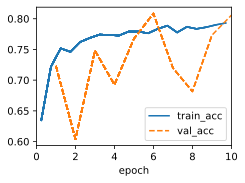

In [10]:
data = CorrFashionMNIST(detector=model, batch_size=256)
model2 = CorrSoftmaxRegression(num_outputs=10, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model2, data)
y_hat=model2.net(data.val_X)
print(f'acc:{model2.accuracy(y_hat, data.val_y):.2f}')

4. Besides distribution shift, what else could affect how the empirical risk approximates the risk?

The size of the trainning dataset and the model complexity.

https://pandalab.me/archives/environment_and_distribution_shift